In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression, PLSCanonical
from sklearn.linear_model import LogisticRegression, Ridge

from scipy.stats import pearsonr
from tqdm import tqdm

# Preprocessing steps

In [2]:
date = '25.05.13'

In [3]:
fixed = pd.read_csv('../EN00_03.28.23.csv')

#separate numerical and non-numerical data
df_cleaned_num = fixed.select_dtypes(exclude=['object'])
df_cleaned_cat = fixed.select_dtypes(include=['object'])

#dummy-code all categorical data
df_cleaned_cat = pd.get_dummies(df_cleaned_cat, dummy_na=False)
print(df_cleaned_cat.shape)

#merge back categorical and numerical variables
df_cleaned_merged = df_cleaned_num.join(df_cleaned_cat)
print(df_cleaned_merged.shape)
fixed=df_cleaned_merged
fixed_cols= list(fixed.columns)
print(len(fixed_cols))
fixed_cols.append('APOE')

#version with statins intake 
balanced_df = pd.read_csv('../apoe_fh_balanced_df_03.28.23.csv', index_col=0)
print(balanced_df.shape)

(384, 86)
(384, 184)
184
(432, 331)


In [4]:
baseline_df = balanced_df[fixed_cols].drop(columns=['APOE',
 'APOE_3 2',
 'APOE_3 3',
 'APOE_4 2',
 'APOE_4 3',
 'APOE_4 4',])

cca_cols = []
for i in range(1,51):
    cca_cols.append(f"{i}")

#keep one-hot encoded APOE genotypes
#APOE e4e4 excluded
apoe_gen = [ 'APOE_3 2',
 'APOE_3 3',
 'APOE_4 3']

balanced_df = balanced_df.drop(columns=['APOE','APOE_4 2','APOE_4 4'])

In [5]:
#all Prevent_AD columns
all_phens_cols = list(balanced_df.drop(columns=apoe_gen).drop(columns=cca_cols).drop(columns=['CandID','Candidate_Age_MoCA','Candidate_Age_lab']).columns)
all_phens_cols

#ALL columns (except APOE genotypes)
all_cols = all_phens_cols.copy()
for col in cca_cols:
    all_cols.append(col)

# Data normalization and standarization 
scaler = StandardScaler()
z_df = scaler.fit_transform(balanced_df)
z_df_df = pd.DataFrame(z_df, columns = balanced_df.columns)

df = balanced_df.reset_index()

# Store indices for males and females
id_f = np.where(df.Sex_Female==1)
id_m = np.where(df.Sex_Male==1)
id_all = df.index

z_df_df.CandID = balanced_df.CandID

In [6]:
# columns to remove from PLS-R models to keep for regression models or later steps (e.g. subgrouping)
cols_reg =  ['Sex_Female',
             'Sex_Male', 
             'father_dx_ad_dementia',
             'mother_dx_ad_dementia',
             'sibling_dx_ad_dementia',
             'time_diff',
             'Age_baseline_months']

# X columns set for the PLS-R models
all_phens_cols = list(balanced_df.drop(columns=apoe_gen).drop(columns=cca_cols).drop(columns=[
    'CandID',
    'Candidate_Age_MoCA',
    'Candidate_Age_lab',
    'RBANS_version_A',
    'RBANS_version_B',
    'RBANS_version_C',
    'RBANS_version_D',
    'comments',
    'only_father',
    'only_mother',
    'both']).drop(columns=cols_reg).columns)

# SUBGROUPING
# maternal AD
id_mat = np.where(z_df_df.only_mother>0)
df_mat = z_df_df.iloc[id_mat]
# paternal AD
id_pat = np.where(z_df_df.only_father>0)
df_pat = z_df_df.iloc[id_pat]
# males
id_males = np.where(z_df_df.Sex_Male>0)
df_males = z_df_df.iloc[id_males]
# females
id_females = np.where(z_df_df.Sex_Female>0)
df_females = z_df_df.iloc[id_females]

In [7]:
print(z_df_df.shape)

(432, 328)


## Useful functions

In [8]:
def partial_least_square(df, x_cols, y_cols,comp,plot,tag):

    """
    Fit a PLS regression model and optionally plot Y loadings.

    Parameters:
    - df: pandas.DataFrame, the input data.
    - x_cols: list of str, predictor column names.
    - y_cols: list of str, response column names.
    - n_components: int, number of PLS components.
    - plot: bool, whether to plot the Y loadings.
    - tag: str, used for plot titles and filenames.

    Returns:
    - fitted PLSRegression object.
    """
   
    pls = PLSRegression(n_components=comp)
    pls.fit(df[x_cols],df[y_cols])
    if plot:

        figure(figsize=(4, 4), dpi=200)
        sns.heatmap(
            pls.y_loadings_[:, :3],
            cmap=plt.cm.RdBu_r,
            center=0,
            vmin=-0.4, vmax=0.4,
            square=True,
            annot=True,
            yticklabels=[r'$\mathit{APOE}\ \epsilon$3/2',
                         r'$\mathit{APOE}\ \epsilon$3/3',
                         r'$\mathit{APOE}\ \epsilon$3/4'],
            xticklabels=[f'Comp {i+1}' for i in range(3)],
            cbar_kws={"shrink": 0.4}
        )
        plt.title(f'Y loadings for PLS-R on {tag}')
        plt.xlabel('PLS-R components')
        plt.subplots_adjust(top=1)
        output_path = f'{date}/{tag}_pls_y_loadings_all_time_points_.png'
        plt.savefig(output_path, dpi=200, bbox_inches='tight')
        plt.show()
        plt.close('all')
    
    return pls

In [9]:
def pls_loadings(dff, idx, tag):

    """
    Fit PLS on input data and return transformed latent components with time info.

    Parameters:
    - dff: DataFrame, data to be used for PLS fitting.
    - idx: list-like, indices corresponding to rows in `balanced_df` for time labels.
    - tag: str, label for saving plots and file outputs.
    - n_components: int, number of PLS components to extract.
    - plot: bool, whether to generate and save loading plots.

    Returns:
    - latent_factors_df: DataFrame with latent components and 'time' column.
    - pls_model: Trained PLSRegression object.
    """
    
    pls = partial_least_square(dff, all_phens_cols,apoe_gen,comp=3, plot=True, tag=tag)
    latent_factors_pls = pls.transform(dff[all_phens_cols])
    latent_factors_pls_df = pd.DataFrame(latent_factors_pls, columns=['C1', 'C2', 'C3'])
    
    return latent_factors_pls_df, pls


In [10]:
def regress_adrd(latent_factors, target, idx, tag):
    """
    Run logistic regression predicting ADRD from latent factors and interactions,
    and plot coefficients heatmaps separately for HC and DN patterns.
    """
    # Build the column names for main effects and interactions
    factor_names = latent_factors.columns.tolist()
    predictors = ['HC-DN_pattern'] + [f'PLS_{name}' for name in factor_names]
    predictors += [f'HC-DN_pattern_PLS_{name}' for name in factor_names]

    # Store regression coefficients
    coef_table = []

    for cca_col in cca_cols:
        # Prepare design matrix
        main_var = z_df_df.loc[idx, cca_col].values.reshape(-1, 1)  # Main effect
        pls_vars = latent_factors.loc[idx].values  # Latent factors
        
        # Interaction terms
        interactions = main_var * pls_vars  # Element-wise multiplication
        X = np.hstack([main_var, pls_vars, interactions])

        # Target
        y = df.loc[idx, target].values

        # Fit logistic regression
        model = LogisticRegression(max_iter=10000)
        model.fit(X, y)
        
        coef_table.append(model.coef_.flatten())

    # Assemble into a DataFrame
    coef_df = pd.DataFrame(coef_table, columns=predictors)
    coef_df.index = [f'Component: {col}' for col in cca_cols]

    # --- Plotting
    def plot_coefficients(data, start, end, title_suffix):
        plt.figure(figsize=(8, 6), dpi=80)
        sns.heatmap(
            data.iloc[start:end].T,
            cmap=plt.cm.RdBu_r, center=0, square=True,
            cbar_kws={"shrink": 0.2},
            vmin=-0.5, vmax=0.5,
            xticklabels=range(1, end-start+1)
        )
        plt.title(f'Regression of maternal history of ADRD on Prevent-AD latent factors ({title_suffix})')
        plt.xlabel('Mode expressions')
        plt.tight_layout()
        plt.show()

    # Plot HC (first 25) and DN (next 25)
    plot_coefficients(coef_df, 0, 25, f'{tag} - HC')
    plot_coefficients(coef_df, 25, coef_df.shape[0], f'{tag} - DN')

    return coef_df


In [11]:
def regress_adrd_shuffled(latent_factors_pls_df, target, idx=id_all, tag='all'):
    tables = []

    # Column names
    pls_cols = list(latent_factors_pls_df.columns)
    cols = ['HC-DN_pattern'] + [f'PLS_{col}' for col in pls_cols] + [f'HC-DN_pattern_PLS_{col}' for col in pls_cols]

    for i in tqdm(range(1000)):
        np.random.seed(i)
        table = []
        index = []

        for col in cca_cols:
            # Prepare regressors
            base_regressor = z_df_df[[col]].iloc[idx].to_numpy()
            pls_regressors = latent_factors_pls_df.iloc[idx].to_numpy()
            
            interactions = np.array([
                base_regressor.squeeze() * pls_regressors[:, j]
                for j in range(pls_regressors.shape[1])
            ]).T

            regressors = np.hstack([base_regressor, pls_regressors, interactions])

            # Fit logistic regression on shuffled labels
            model = LogisticRegression(max_iter=10000)
            y = df[target].iloc[idx].to_numpy()
            np.random.shuffle(y)
            model.fit(regressors, y)

            coefs = model.coef_.flatten()
            table.append(coefs)
            index.append(f'Component: {int(col)}')

        # Collect results
        table_df = pd.DataFrame(table, columns=cols, index=index)
        tables.append(table_df)

    # Concatenate all shuffled iterations
    result = pd.concat(tables)
    return result


In [12]:
def compute_pvals(real_df, shuffled_df, n_components=50):
    """
    Compute empirical p-values for each coefficient based on a shuffled null distribution.

    Parameters:
    - real_df: DataFrame of real coefficients (components x variables)
    - shuffled_df: DataFrame of shuffled coefficients (components x variables)
    - n_components: Number of components to consider (default = 50)

    Returns:
    - DataFrame of empirical p-values (same shape as real_df)
    """
    pval_df = pd.DataFrame(index=[f'Component: {n}' for n in range(1, n_components + 1)],
                           columns=real_df.columns)

    for n in range(1, n_components + 1):
        real_coefs = real_df.loc[f'Component: {n}']
        shuffled_coefs = shuffled_df.loc[f'Component: {n}']

        for var in real_coefs.index:
            real_val = real_coefs[var]
            null_dist = shuffled_coefs[var]

            if real_val < 0:
                p_val = (null_dist < real_val).sum() / len(null_dist)
            else:
                p_val = (null_dist > real_val).sum() / len(null_dist)

            pval_df.at[f'Component: {n}', var] = p_val

    return pval_df

In [13]:
def plot_masked(tdff,mask,p,tag):
    masked_df=tdff[mask<(p/2)]

    figure(figsize=(8, 6), dpi=80)
    sns.heatmap(masked_df.iloc[:25,:].T, cmap=plt.cm.RdBu_r, center=0, square=True, cbar_kws={"shrink": 0.2}, vmin=-0.55, vmax=0.55,xticklabels=range(1,26))
    plt.title(f'Regression of maternal history of ADRD on the Prevent-AD latent factors for {tag}')
    plt.xlabel('HC mode expressions')
    plt.subplots_adjust(top=1)
    #plt.savefig(f'{date}/linear_regression_coefficients_ad_{tag}_hc.png', dpi=200, bbox_inches='tight')
    #plt.show()

    #figure(figsize=(8, 6), dpi=80)
    sns.heatmap(masked_df.iloc[25:,:].T, cmap=plt.cm.RdBu_r, center=0, square=True, cbar_kws={"shrink": 0.2}, vmin=-0.55, vmax=0.55, xticklabels=range(1,26))
    plt.title(f'Regression of maternal history of ADRD on the Prevent-AD latent factors for {tag}')
    plt.xlabel('DN mode expressions')
    #plt.ylabel('HC & DN Canonical variates')
    plt.subplots_adjust(top=1)
    #plt.savefig(f'{date}/linear_regression_coefficients_ad_{tag}_dn.png', dpi=200, bbox_inches='tight')
    plt.show()

## PLS-R on all participants

In [14]:
date = '25.05.13'

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

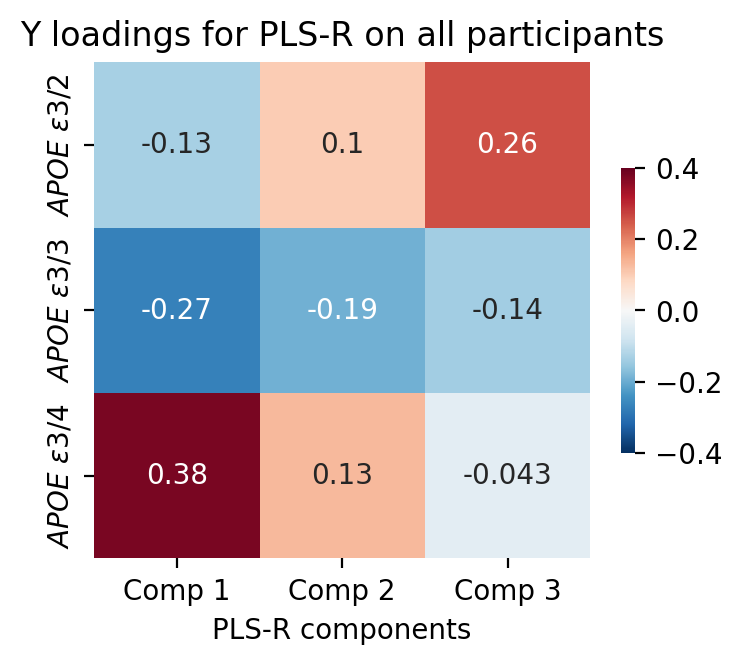

In [16]:
latent_factors_pls_df, pls = pls_loadings(z_df_df,z_df_df.index, 'all participants')

In [17]:
print(pls.y_loadings_)

[[-0.13260767  0.10008721  0.25640482]
 [-0.26887559 -0.19369154 -0.14060361]
 [ 0.37959435  0.12815011 -0.04346157]]


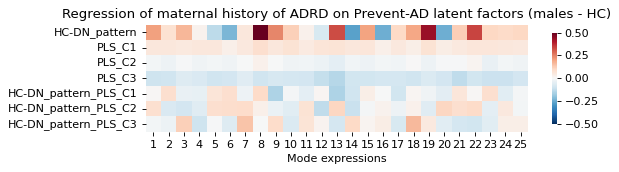

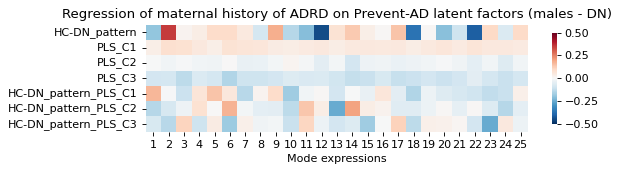

100%|██████████| 1000/1000 [05:04<00:00,  3.29it/s]


In [18]:
tables_m = regress_adrd(latent_factors_pls_df.copy(), 'only_mother', id_m, 'males')
tables_m.to_csv(f'{date}/tables_m.csv')
# Permutation analyses
shuffled_tables_m = regress_adrd_shuffled(latent_factors_pls_df.copy(), 'only_mother', id_m, 'males')
# Compute empirical p-values
pvals_df_m = compute_pvals(tables_m, shuffled_tables_m)

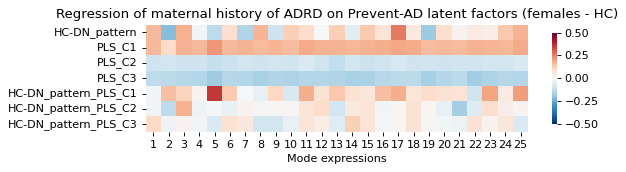

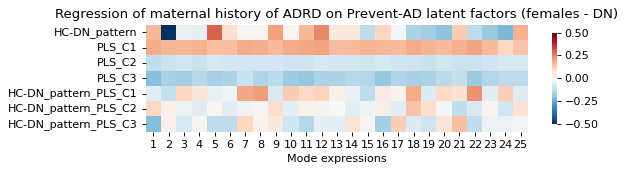

100%|██████████| 1000/1000 [04:38<00:00,  3.60it/s]


In [19]:
tables_f = regress_adrd(latent_factors_pls_df, 'only_mother', id_f, 'females')
tables_f.to_csv(f'{date}/tables_f.csv')
# Permutation analyses
shuffled_tables_f = regress_adrd_shuffled(latent_factors_pls_df, 'only_mother', id_f, 'females')
# Compute empirical p-values
pvals_df_f = compute_pvals(tables_f, shuffled_tables_f)

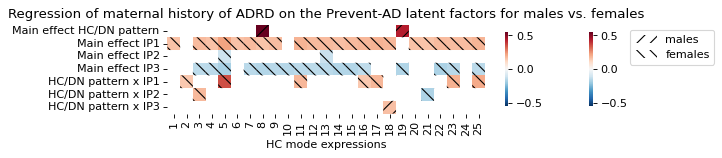

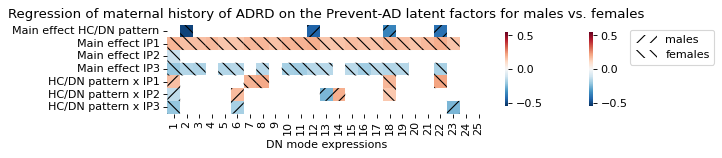

In [20]:
# Set common parameters
p = 0.05
ylabels = [
    'Main effect HC/DN pattern',
    'Main effect IP1',
    'Main effect IP2',
    'Main effect IP3',
    'HC/DN pattern x IP1',
    'HC/DN pattern x IP2',
    'HC/DN pattern x IP3',
]

# HC part (rows 0-25)
figure(figsize=(8, 6), dpi=80)

for tables, pvals, tag, hatch_style in [
    (tables_m, pvals_df_m, 'males', '//'),
    (tables_f, pvals_df_f, 'females', '\\\\')
]:
    masked_df = tables[pvals < (p / 2)]
    
    sns.heatmap(
        masked_df.iloc[:25, :].T, 
        cmap=plt.cm.RdBu_r, center=0, square=True,
        cbar_kws={"shrink": 0.2},
        vmin=-0.55, vmax=0.55,
        xticklabels=range(1, 26),
        yticklabels= ylabels,
    )
    
    # Add hatch for both males and females
    plt.pcolor(masked_df.iloc[:25, :].T, hatch=hatch_style, alpha=0.)

plt.title('Regression of maternal history of ADRD on the Prevent-AD latent factors for males vs. females')
plt.xlabel('HC mode expressions')
plt.legend(['males', 'females'], loc='upper right', bbox_to_anchor=(1.74, 1))
plt.savefig(f'{date}/linear_regression_coefficients_ad_hc.png', dpi=200, bbox_inches='tight')
plt.show()

# DN part (rows 25+)
figure(figsize=(8, 6), dpi=80)

for tables, pvals, tag, hatch_style in [
    (tables_m, pvals_df_m, 'males', '//'),
    (tables_f, pvals_df_f, 'females', '\\\\')
]:
    # Two-tailed test
    masked_df = tables[pvals < (p / 2)]
    
    sns.heatmap(
        masked_df.iloc[25:, :].T, 
        cmap=plt.cm.RdBu_r, center=0, square=True,
        cbar_kws={"shrink": 0.2},
        vmin=-0.55, vmax=0.55,
        xticklabels=range(1, 26),
        yticklabels= ylabels,
    )
    
    plt.pcolor(masked_df.iloc[25:, :].T, hatch=hatch_style, alpha=0.)

plt.title('Regression of maternal history of ADRD on the Prevent-AD latent factors for males vs. females')
plt.xlabel('DN mode expressions')
plt.legend(['males', 'females'], loc='upper right', bbox_to_anchor=(1.74, 1))
plt.savefig(f'{date}/linear_regression_coefficients_ad_dn.png', dpi=200, bbox_inches='tight')
plt.show()


# Plotting PLS projections

In [21]:
from nilearn import datasets as ds
from nilearn.maskers import NiftiLabelsMasker, NiftiMasker
from nilearn.image import resample_img, index_img
import nilearn.datasets as ds
from nilearn import plotting

In [22]:
# Hippocampus (HC) data 
BL00_HC = pd.read_csv('../HC_segmentation/csv/BL00_HC_left_right.csv', index_col=0)
col_HC = list(BL00_HC.columns)[0:-4]
col_HC.remove('Whole_hippocampal_body_left')
col_HC.remove('Whole_hippocampal_head_left')
col_HC.remove('Whole_hippocampus_left')
col_HC.remove('PSCID_left')

# Default network (DN) data
BL00_DN = pd.read_csv('../BL00_DN.csv', index_col=0)
col_DN = BL00_DN.columns

In [23]:
date = '25.05.13'

lh_7Networks_LH_Default_pCunPCC_4_volume     -0.120470
rh_7Networks_RH_Default_Par_1_volume         -0.108891
rh_7Networks_RH_Default_pCunPCC_1_volume     -0.105710
rh_7Networks_RH_Default_Par_3_volume         -0.095722
lh_7Networks_LH_Default_PFC_2_volume         -0.086921
                                                ...   
rh_7Networks_RH_Default_PFCdPFCm_7_volume     0.106024
rh_7Networks_RH_Default_PFCdPFCm_13_volume    0.107820
rh_7Networks_RH_Default_PFCdPFCm_9_volume     0.116216
rh_7Networks_RH_Default_PFCdPFCm_11_volume    0.136017
lh_7Networks_LH_Default_PFC_18_volume         0.141819
Length: 91, dtype: float64


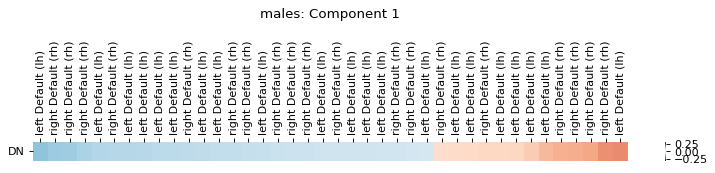

lh_7Networks_LH_Default_PFC_16_volume       -0.143940
rh_7Networks_RH_Default_pCunPCC_6_volume    -0.143369
lh_7Networks_LH_Default_pCunPCC_7_volume    -0.135609
rh_7Networks_RH_Default_PFCdPFCm_9_volume   -0.133636
lh_7Networks_LH_Default_pCunPCC_11_volume   -0.132425
                                               ...   
lh_7Networks_LH_Default_Temp_5_volume        0.027147
rh_7Networks_RH_Default_PFCdPFCm_6_volume    0.040475
lh_7Networks_LH_Default_pCunPCC_4_volume     0.043474
rh_7Networks_RH_Default_PFCv_1_volume        0.043835
rh_7Networks_RH_Default_Temp_3_volume        0.074292
Length: 91, dtype: float64


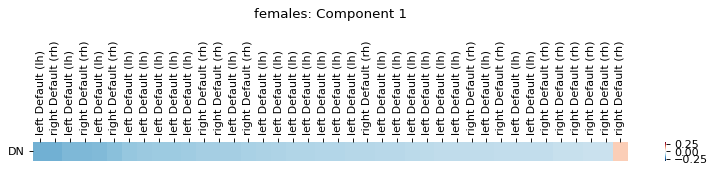

lh_7Networks_LH_Default_pCunPCC_9_volume    -0.050717
rh_7Networks_RH_Default_PFCv_1_volume       -0.034137
lh_7Networks_LH_Default_PFC_1_volume        -0.033084
lh_7Networks_LH_Default_pCunPCC_8_volume    -0.002972
rh_7Networks_RH_Default_Par_1_volume         0.001508
                                               ...   
lh_7Networks_LH_Default_Temp_1_volume        0.175646
lh_7Networks_LH_Default_PFC_16_volume        0.179974
rh_7Networks_RH_Default_PFCdPFCm_5_volume    0.182966
rh_7Networks_RH_Default_PFCdPFCm_7_volume    0.183827
lh_7Networks_LH_Default_Temp_8_volume        0.208546
Length: 91, dtype: float64


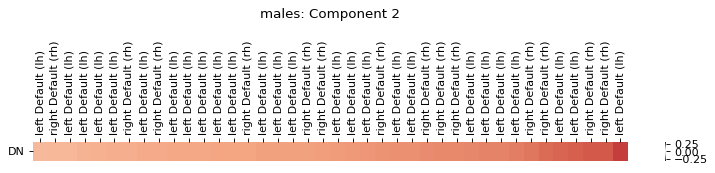

lh_7Networks_LH_Default_Par_3_volume       -0.111952
rh_7Networks_RH_Default_Temp_3_volume      -0.105489
lh_7Networks_LH_Default_Temp_10_volume     -0.102200
rh_7Networks_RH_Default_PFCv_3_volume      -0.101764
lh_7Networks_LH_Default_PFC_3_volume       -0.099210
                                              ...   
lh_7Networks_LH_Default_PFC_23_volume      -0.016697
rh_7Networks_RH_Default_PFCv_1_volume      -0.014857
lh_7Networks_LH_Default_PFC_1_volume       -0.013087
rh_7Networks_RH_Default_pCunPCC_4_volume    0.000332
rh_7Networks_RH_Default_pCunPCC_2_volume    0.004041
Length: 91, dtype: float64


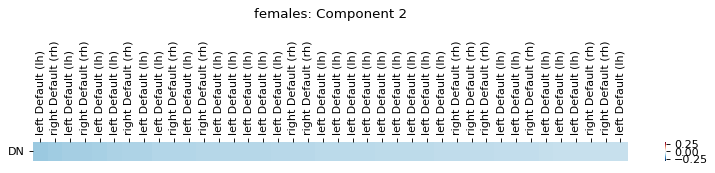

lh_7Networks_LH_Default_PFC_24_volume        -0.162982
rh_7Networks_RH_Default_PFCdPFCm_6_volume    -0.120375
lh_7Networks_LH_Default_Par_6_volume         -0.119047
lh_7Networks_LH_Default_PFC_23_volume        -0.112093
rh_7Networks_RH_Default_PFCdPFCm_13_volume   -0.105732
                                                ...   
lh_7Networks_LH_Default_PFC_9_volume          0.028456
rh_7Networks_RH_Default_PFCdPFCm_7_volume     0.033414
rh_7Networks_RH_Default_PFCv_4_volume         0.048084
lh_7Networks_LH_Default_pCunPCC_4_volume      0.060504
rh_7Networks_RH_Default_PFCv_1_volume         0.066845
Length: 91, dtype: float64


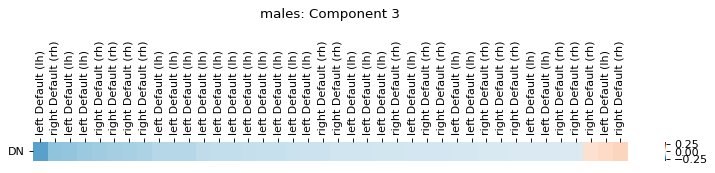

lh_7Networks_LH_Default_PFC_18_volume        -0.056896
lh_7Networks_LH_Default_PFC_23_volume        -0.029859
lh_7Networks_LH_Default_PFC_24_volume        -0.027760
rh_7Networks_RH_Default_PFCdPFCm_11_volume   -0.015008
rh_7Networks_RH_Default_Temp_6_volume        -0.005706
                                                ...   
rh_7Networks_RH_Default_Par_4_volume          0.150505
rh_7Networks_RH_Default_PFCdPFCm_6_volume     0.153561
lh_7Networks_LH_Default_Temp_9_volume         0.158763
lh_7Networks_LH_Default_PFC_4_volume          0.170197
lh_7Networks_LH_Default_pCunPCC_2_volume      0.178972
Length: 91, dtype: float64


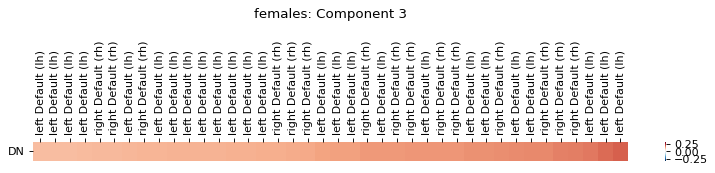

In [24]:
# Loop over PLS components 
for i in range(1, 4):
    for sex in ['males', 'females']:
        
        # Load data for DN projections
        dn_path = f'{date}/brain_imaging/interactions_pls_c{i}_dn_{sex}_age_not_regressed_2025.csv'
        dn = pd.read_csv(dn_path, names=col_DN)
        
        # Print sorted mean projections for inspection
        print(dn.mean().sort_values())
        
        # Get top 40 regions with highest absolute mean projection
        top_ids = dn.mean().abs().sort_values(ascending=False).head(40).index
        
        # Order these regions by signed mean value (low to high)
        ids_ordered = dn.mean()[top_ids].sort_values().index
        
        # Generate cleaned region labels
        new_labels = []
        for col in ids_ordered:
            col = col.replace('LH', 'left').replace('RH', 'right')
            parts = col.split('_')
            # Safe check for expected naming pattern
            if len(parts) >= 4:
                name = f"{parts[2]}_{parts[3]}_({parts[0]})"
                name = name.replace('_', ' ')
            else:
                name = col  # fallback
            new_labels.append(name)
        
        # Create the heatmap
        plt.figure(figsize=(12, 0.3), dpi=80)
        ax = sns.heatmap(
            pd.DataFrame(dn.mean()[ids_ordered], columns=['DN']).T,
            cmap=plt.cm.RdBu_r,
            vmin=-0.30, vmax=0.30,
            xticklabels=new_labels
        )
        
        # Adjust aesthetics
        ax.xaxis.tick_top()
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.title(f'{sex}: Component {i}', pad=20)
        
        # Save figure
        output_path = f'{date}/brain_imaging/{sex}_dn_projections_pls_c{i}_2025.png'
        plt.savefig(output_path, dpi=200, bbox_inches='tight')
        plt.show()
        plt.close()

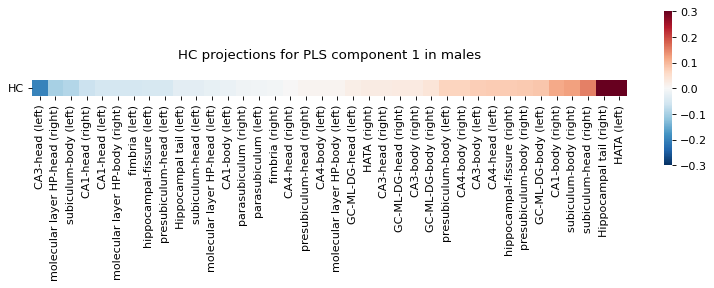

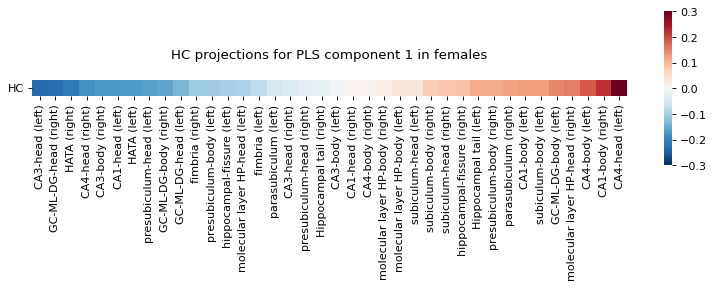

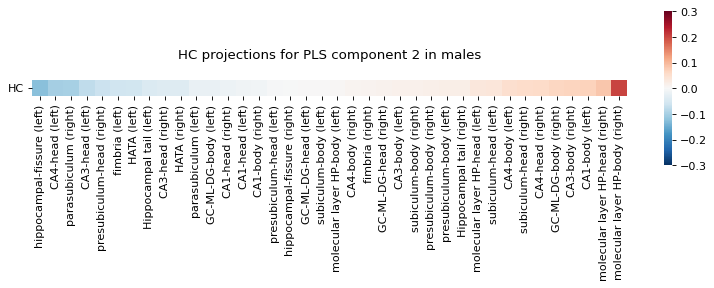

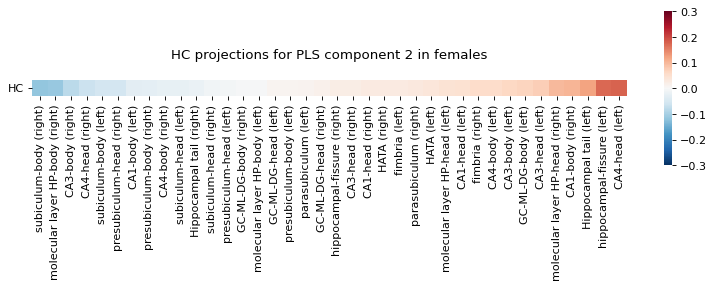

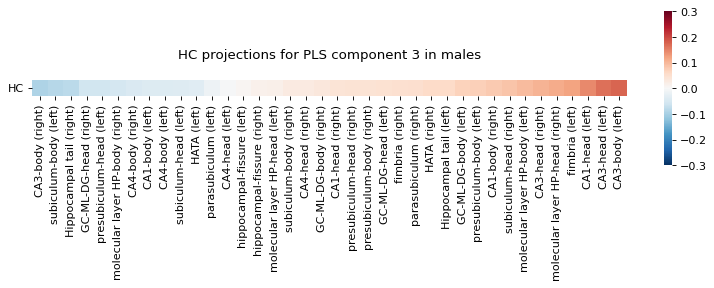

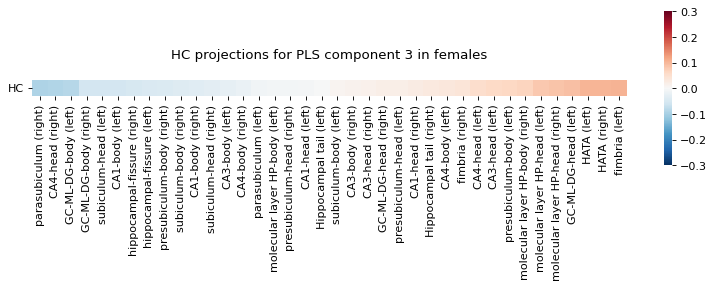

In [25]:
# Loop over 3 PLS components
for i in range(1, 4):
    for sex in ['males', 'females']:
        
        # Load HC projection values and compute mean per region
        hc_path = f'{date}/brain_imaging/interactions_pls_c{i}_hc_{sex}_age_not_regressed_2025.csv'
        hc_mean = pd.read_csv(hc_path, names=col_HC).mean().sort_values()
        
        # Clean region labels for plot display
        cleaned_labels = []
        for col in hc_mean.index:
            label = col.replace('_', ' ')
            label = label.replace('right', '(right)').replace('left', '(left)')
            cleaned_labels.append(label)
        
        # Create the heatmap
        plt.figure(figsize=(12, 5), dpi=80)
        ax = sns.heatmap(
            pd.DataFrame(hc_mean, columns=['HC']).T,
            square=True,
            cbar_kws={"shrink": 0.5},
            cmap=plt.cm.RdBu_r,
            vmin=-0.30, vmax=0.30,
            xticklabels=cleaned_labels
        )
        
        # Adjust plot aesthetics
        plt.title(f'HC projections for PLS component {i} in {sex}', pad=20)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        
        # Save and display plot
        output_path = f'{date}/brain_imaging/{sex}_hc_projections_pls_c{i}_2025.png'
        plt.savefig(output_path, dpi=200, bbox_inches='tight')
        plt.show()
        plt.close()


In [26]:
yeo = ds.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7)
# dump DMN results in nifti format
masker = NiftiLabelsMasker(labels_img=yeo.maps)
masker.fit()

NiftiLabelsMasker(labels_img='/Users/chloesavignac/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz')

In [27]:
# Loop over 3 PLS components
for i in range(3):
    
    # ---------------------------
    # Males
    # ---------------------------
    # Load DN interaction weights for males and average across rows
    dn = pd.read_csv(f'{date}/brain_imaging/interactions_pls_c{i+1}_dn_males_age_not_regressed_2025.csv', names=col_DN)
    dn = dn.mean()

    # Identify DMN regions from the Yeo atlas
    b_is_DMN = pd.Series(np.array(yeo.labels, dtype=str)).str.contains('Default').values

    # Initialize zero array for 400 brain regions and assign weights to DMN regions only
    out_DMN_weights = np.zeros((1, 400))
    out_DMN_weights[0, b_is_DMN] = dn.values

    # Reconstruct and save the Nifti image
    out_nii = masker.inverse_transform(out_DMN_weights)
    out_nii.to_filename(f'{date}/brain_imaging/males_IP{i+1}.nii.gz')
    
    # ---------------------------
    # Females
    # ---------------------------
    # Load DN interaction weights for females and average across rows
    dn = pd.read_csv(f'{date}/brain_imaging/interactions_pls_c{i+1}_dn_females_age_not_regressed_2025.csv', names=col_DN)
    dn = dn.mean()

    # Identify DMN regions from the Yeo atlas
    b_is_DMN = pd.Series(np.array(yeo.labels, dtype=str)).str.contains('Default').values

    # Initialize zero array for 400 brain regions and assign weights to DMN regions only
    out_DMN_weights = np.zeros((1, 400))
    out_DMN_weights[0, b_is_DMN] = dn.values

    # Reconstruct and save the Nifti image
    out_nii = masker.inverse_transform(out_DMN_weights)
    out_nii.to_filename(f'{date}/brain_imaging/females_IP{i+1}.nii.gz')


In [ ]:
for i in range(1, 4):
    # Plot for females
    stat_img = f'{date}/brain_imaging/females_IP{i}.nii.gz'
    display = plotting.plot_stat_map(stat_img,
                          display_mode='mosaic',
                          cut_coords=10,
                          cmap='RdBu_r',
                          symmetric_cbar=True,
                          vmax=0.30,
                          threshold=0,
                          black_bg=True,
                        #   output_file=f'{date}/brain_imaging/10_all_females_IP{i}.png'
                          )

    display.title(f'Intermediate phenotype {i}: Females', size=30)
    
    # Plot for males
    stat_img = f'{date}/brain_imaging/males_IP{i}.nii.gz'
    display = plotting.plot_stat_map(stat_img,
                           display_mode='mosaic',
                           cut_coords=10,
                           cmap='RdBu_r',
                           symmetric_cbar=True,
                           vmax=0.30,
                           threshold=0,
                           black_bg=True,
                        #    output_file=f'{date}/brain_imaging/10_all_males_IP{i}.png',
                           )
    
    display.title(f'Intermediate phenotype {i}: Males', size=30)
